# **Import Libraries**

In [21]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
import os
from tqdm import tqdm
from torchvision import datasets, transforms
from sklearn import svm
import random

try:
    import dill as pickle
except ImportError:
    import pickle

# **Model Structure**

##**Args:**

*   **input_dim (int):** Dimensionality of the input data (e.g., image size).
*   **latent_dim (int):** Dimensionality of the latent space.

##**Attributes:**

*   **fc1 (nn.Linear):** First fully connected layer for encoding.
*   **fc2_mean (nn.Linear):** Layer for mean of latent space.
*   **fc2_logvar (nn.Linear):** Layer for log variance of latent space.
*   **fc3 (nn.Linear):** First fully connected layer for decoding.
*   **fc4 (nn.Linear):** Final layer for reconstructing input data.

##**Methods:**

*   **encode(x):** Encodes input data to mean and log variance of latent space.
*   **reparameterize(mean, logvar):** Samples from the latent space using reparameterization trick, enabling backpropagation
*   **decode(z):** Decodes latent representation to reconstruct input data.
*   **forward(x):** Computes reconstructed data, mean, and log variance.

In [22]:
# Define the VAE model
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 256),
            nn.ReLU(),
            nn.Linear(256, 2 * latent_dim)  # Output mean and log variance
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 64 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()  # Use sigmoid for Bernoulli distribution
        )

    def encode(self, x):
        h = self.encoder(x)
        mean, logvar = h[:, :self.latent_dim], h[:, self.latent_dim:]
        return mean, logvar

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mean + eps * std
        return z

    def decode(self, z):
        x = self.decoder(z)
        return x

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        reconstructed_x = self.decode(z)
        return reconstructed_x, mean, logvar

'# Define the SVM classifier\nclass SVM(nn.Module):\n    def __init__(self):\n        super(SVM, self).__init__()\n        self.fc1 = nn.Linear(10, 50)\n        self.fc2 = nn.Linear(50, 2)\n        self.fc3 = nn.Linear(2, 1)\n\n    def forward(self, x):\n        x = F.relu(self.fc1(x))\n        x = F.relu(self.fc2(x))\n        x = self.fc3(x)\n        return x\n'

# **Params**

In [23]:
# Hyperparameters
batchSize = 512
learningRate = 1e-3
epochs = 100
labelsNum = [100, 600, 1000, 3000]
accuracies_mnist = []
accuracies_fashion_mnist = []
inputDim = 784 # MNIST image size (28x28)
latentDim = 50

# Set Models
vaeMNIST = VAE(inputDim, latentDim)
vaeFashionMNIST = VAE(inputDim, latentDim)

optimizer_mnist = optim.Adam(vaeMNIST.parameters(), lr = learningRate)
optimizer_fashion_mnist = optim.Adam(vaeFashionMNIST.parameters(), lr = learningRate)

# Check if GPU is available or not
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


# **Fashion MNIST dataset Loading**

Load both FashionMNIST and MNIST datasets

In [24]:
transform = transforms.Compose([transforms.ToTensor()])

# Define the data sets
train_dataset_mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset_mnist = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_dataset_fashion_mnist = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset_fashion_mnist = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Define the data loaders
test_loader_mnist = DataLoader(test_dataset_mnist, batch_size=batchSize)
test_loader_fashion_mnist = DataLoader(test_dataset_fashion_mnist, batch_size=batchSize)

# **Functions**

In [28]:
def vaeLoss(recon_data, data, mu, logvar):

  # Reconstruction Loss
  recon_loss = F.binary_cross_entropy(recon_data, data, reduction = 'sum')

  # KL Divergence Loss
  kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - torch.exp(logvar))

  #  Total Loss
  loss = recon_loss + kl_loss

  return loss


def train_vae_svm(vae, train_dataset, test_dataset, test_loader, device, epochs, batchSize, labelsNum, accuracies, optimizer):

    for n in labelsNum:
        # Select an equal number of labled examples from each class
        labeled = []
        for i in range(10):
            label_idx = np.where(train_dataset.targets == i)[0]
            labeled.extend(list(np.random.choice(label_idx, n//10, replace=False)))

        # Select an equal number of unlabled examples from each class
        unlabeled = list(set(range(len(train_dataset.data))) - set(labeled))

        # Create labeled and unlabeled data loaders
        labeled_loader = DataLoader(train_dataset, batch_size=batchSize, sampler=torch.utils.data.SubsetRandomSampler(labeled))
        unlabeled_loader = DataLoader(train_dataset, batch_size=batchSize, sampler=torch.utils.data.SubsetRandomSampler(unlabeled))

        # VAE Training
        for epoch in range(epochs):
            vae.train()
            vae.to(device)
            trainLoss = 0
            for batch_i, (data, _) in enumerate(labeled_loader):
                data = data.to(device)
                data = data.reshape(-1, 1, 28, 28)
                optimizer.zero_grad()
                recon_data, mu, logvar = vae(data)
                loss = vaeLoss(recon_data, data, mu, logvar)
                loss.backward()
                trainLoss += loss.item()
                optimizer.step()

            print(f'Training Epoch {epoch+1}/{epochs}, Loss: {trainLoss/(batch_i+1):.4f}')

        # Get latent representation
        vae.eval()

        testLoss = 0
        latentLabled = []
        labledTarget = []
        latentTest = []
        testTarget = []

        for inputs, targets in tqdm(labeled_loader):
            with torch.no_grad():
                inputs, targets = inputs.to(device), targets.to(device)
                # Get the latent representation
                inputs = inputs.reshape(-1, 1, 28, 28)
                latentData, _ = vae.encode(inputs)
                latentLabled.append(latentData)
                labledTarget.append(targets)
        latentLabled = torch.cat(latentLabled, dim=0)
        labledTarget = torch.cat(labledTarget)

        for data, targets in tqdm(test_loader):
            with torch.no_grad():
                data, targets = data.to(device), targets.to(device)
                # Get the latent representation
                data = data.reshape(-1, 1, 28, 28)
                latentData, _ = vae.encode(data)
                latentTest.append(latentData)
                testTarget.append(targets)
        latentTest = torch.cat(latentTest, dim=0)
        testTarget = torch.cat(testTarget)

        # Train the SVM classifier (using RBF kernel)
        clf = svm.SVC(kernel='rbf')
        clf.fit(latentLabled.cpu().numpy(), labledTarget.cpu().numpy())

        # Evaluate on the test set
        test_acc = clf.score(latentTest.cpu().numpy(), testTarget.cpu())
        accuracies.append(test_acc)

        vae.train()
        print(f'Number of labels: {n}, Test accuracy: {test_acc:.4f}')

    print(f'Accuracies: {accuracies}')
    return clf


# **Train & Save models**

In [29]:
# Train and test MNIST
MNIST_clf = train_vae_svm(vaeMNIST, train_dataset_mnist, test_dataset_mnist, test_loader_mnist, device, epochs, batchSize, labelsNum, accuracies_mnist, optimizer_mnist)

# Save the SVM model and VAE weights
torch.save(vaeMNIST.state_dict(), 'vae_MNIST_weights.pth')
with open('svm_MNIST_model.pkl', 'wb') as f:
    pickle.dump(MNIST_clf, f)

# Train and test FashionMNIST
Fashion_clf = train_vae_svm(vaeFashionMNIST, train_dataset_fashion_mnist, test_dataset_fashion_mnist, test_loader_fashion_mnist, device, epochs, batchSize, labelsNum, accuracies_fashion_mnist, optimizer_fashion_mnist)

torch.save(vaeFashionMNIST.state_dict(), 'vae_fashionMNIST_weights.pth')
with open('svm_fashionMNIST_model.pkl', 'wb') as f:
    pickle.dump(Fashion_clf, f)

Training Epoch 1/100, Loss: 10736.1475
Training Epoch 2/100, Loss: 10860.3877
Training Epoch 3/100, Loss: 10716.4424
Training Epoch 4/100, Loss: 10672.2402
Training Epoch 5/100, Loss: 10545.1152
Training Epoch 6/100, Loss: 10475.1514
Training Epoch 7/100, Loss: 10321.8818
Training Epoch 8/100, Loss: 10206.6523
Training Epoch 9/100, Loss: 10228.6387
Training Epoch 10/100, Loss: 10045.1797
Training Epoch 11/100, Loss: 10011.4473
Training Epoch 12/100, Loss: 10016.5869
Training Epoch 13/100, Loss: 9835.5469
Training Epoch 14/100, Loss: 9862.3896
Training Epoch 15/100, Loss: 9755.5566
Training Epoch 16/100, Loss: 9762.7959
Training Epoch 17/100, Loss: 9653.9795
Training Epoch 18/100, Loss: 9623.4160
Training Epoch 19/100, Loss: 9563.2969
Training Epoch 20/100, Loss: 9489.8516
Training Epoch 21/100, Loss: 9429.6748
Training Epoch 22/100, Loss: 9479.4268
Training Epoch 23/100, Loss: 9361.2969
Training Epoch 24/100, Loss: 9343.1172
Training Epoch 25/100, Loss: 9342.8379
Training Epoch 26/100,

100%|██████████| 20/20 [00:01<00:00, 12.66it/s]


Number of labels: 100, Test accuracy: 0.8285
Training Epoch 1/100, Loss: 36402.6577
Training Epoch 2/100, Loss: 35428.9912
Training Epoch 3/100, Loss: 35997.5615
Training Epoch 4/100, Loss: 42307.4722
Training Epoch 5/100, Loss: 49468.5513
Training Epoch 6/100, Loss: 36965.0864
Training Epoch 7/100, Loss: 39662.4214
Training Epoch 8/100, Loss: 35948.7158
Training Epoch 9/100, Loss: 36825.7446
Training Epoch 10/100, Loss: 36668.7949
Training Epoch 11/100, Loss: 34766.9683
Training Epoch 12/100, Loss: 34819.1841
Training Epoch 13/100, Loss: 34598.4561
Training Epoch 14/100, Loss: 33846.7666
Training Epoch 15/100, Loss: 33186.0669
Training Epoch 16/100, Loss: 33146.0420
Training Epoch 17/100, Loss: 32566.1431
Training Epoch 18/100, Loss: 32177.4502
Training Epoch 19/100, Loss: 31925.9370
Training Epoch 20/100, Loss: 31810.5249
Training Epoch 21/100, Loss: 31251.8179
Training Epoch 22/100, Loss: 31111.8408
Training Epoch 23/100, Loss: 30933.8506
Training Epoch 24/100, Loss: 30721.6533
Trai

100%|██████████| 20/20 [00:01<00:00, 19.19it/s]


Number of labels: 600, Test accuracy: 0.9298
Training Epoch 1/100, Loss: 57495.5469
Training Epoch 2/100, Loss: 56181.8379
Training Epoch 3/100, Loss: 55365.3887
Training Epoch 4/100, Loss: 54433.0645
Training Epoch 5/100, Loss: 53861.6133
Training Epoch 6/100, Loss: 53444.7305
Training Epoch 7/100, Loss: 52776.0234
Training Epoch 8/100, Loss: 52548.4023
Training Epoch 9/100, Loss: 52171.1035
Training Epoch 10/100, Loss: 51808.6367
Training Epoch 11/100, Loss: 51546.4883
Training Epoch 12/100, Loss: 51128.5371
Training Epoch 13/100, Loss: 50903.4648
Training Epoch 14/100, Loss: 50772.3535
Training Epoch 15/100, Loss: 50448.3594
Training Epoch 16/100, Loss: 50339.6094
Training Epoch 17/100, Loss: 50168.5703
Training Epoch 18/100, Loss: 50067.7246
Training Epoch 19/100, Loss: 49838.6133
Training Epoch 20/100, Loss: 49591.8574
Training Epoch 21/100, Loss: 49556.2090
Training Epoch 22/100, Loss: 49397.0137
Training Epoch 23/100, Loss: 49349.8164
Training Epoch 24/100, Loss: 49255.2480
Trai

100%|██████████| 20/20 [00:01<00:00, 19.68it/s]


Number of labels: 1000, Test accuracy: 0.9402
Training Epoch 1/100, Loss: 56208.3796
Training Epoch 2/100, Loss: 54544.9512
Training Epoch 3/100, Loss: 53708.3926
Training Epoch 4/100, Loss: 52812.4922
Training Epoch 5/100, Loss: 52396.5677
Training Epoch 6/100, Loss: 51927.5221
Training Epoch 7/100, Loss: 51677.2904
Training Epoch 8/100, Loss: 51405.9707
Training Epoch 9/100, Loss: 51184.9049
Training Epoch 10/100, Loss: 50949.5280
Training Epoch 11/100, Loss: 50765.4049
Training Epoch 12/100, Loss: 50560.6745
Training Epoch 13/100, Loss: 50448.4447
Training Epoch 14/100, Loss: 50327.4557
Training Epoch 15/100, Loss: 50127.3359
Training Epoch 16/100, Loss: 50159.4844
Training Epoch 17/100, Loss: 50069.5345
Training Epoch 18/100, Loss: 49876.6706
Training Epoch 19/100, Loss: 49848.0293
Training Epoch 20/100, Loss: 49677.2988
Training Epoch 21/100, Loss: 49667.4961
Training Epoch 22/100, Loss: 49515.0892
Training Epoch 23/100, Loss: 49452.9772
Training Epoch 24/100, Loss: 49393.0957
Tra

100%|██████████| 20/20 [00:01<00:00, 19.01it/s]


Number of labels: 3000, Test accuracy: 0.9631
Accuracies: [0.8285, 0.9298, 0.9402, 0.9631]
Training Epoch 1/100, Loss: 24982.6719
Training Epoch 2/100, Loss: 25005.0430
Training Epoch 3/100, Loss: 24927.1895
Training Epoch 4/100, Loss: 24864.4434
Training Epoch 5/100, Loss: 24957.4805
Training Epoch 6/100, Loss: 24857.3105
Training Epoch 7/100, Loss: 24787.5410
Training Epoch 8/100, Loss: 24793.1582
Training Epoch 9/100, Loss: 24696.2930
Training Epoch 10/100, Loss: 24679.4688
Training Epoch 11/100, Loss: 24599.3887
Training Epoch 12/100, Loss: 24706.3867
Training Epoch 13/100, Loss: 24655.4512
Training Epoch 14/100, Loss: 24506.0684
Training Epoch 15/100, Loss: 24486.1777
Training Epoch 16/100, Loss: 24476.8848
Training Epoch 17/100, Loss: 24456.4004
Training Epoch 18/100, Loss: 24453.5430
Training Epoch 19/100, Loss: 24472.6289
Training Epoch 20/100, Loss: 24398.9375
Training Epoch 21/100, Loss: 24308.4805
Training Epoch 22/100, Loss: 24332.5645
Training Epoch 23/100, Loss: 24263.996

100%|██████████| 20/20 [00:01<00:00, 19.47it/s]


Number of labels: 100, Test accuracy: 0.7025
Training Epoch 1/100, Loss: 76191.5625
Training Epoch 2/100, Loss: 76278.8613
Training Epoch 3/100, Loss: 79975.3438
Training Epoch 4/100, Loss: 94967.2979
Training Epoch 5/100, Loss: 105735.9336
Training Epoch 6/100, Loss: 94398.5840
Training Epoch 7/100, Loss: 88333.0039
Training Epoch 8/100, Loss: 89534.3369
Training Epoch 9/100, Loss: 86376.0166
Training Epoch 10/100, Loss: 84899.4883
Training Epoch 11/100, Loss: 83522.4219
Training Epoch 12/100, Loss: 82740.6279
Training Epoch 13/100, Loss: 81612.1611
Training Epoch 14/100, Loss: 81122.3965
Training Epoch 15/100, Loss: 79853.4131
Training Epoch 16/100, Loss: 79177.7363
Training Epoch 17/100, Loss: 78797.3203
Training Epoch 18/100, Loss: 78208.2910
Training Epoch 19/100, Loss: 78034.6865
Training Epoch 20/100, Loss: 77279.2930
Training Epoch 21/100, Loss: 76924.6582
Training Epoch 22/100, Loss: 76606.9883
Training Epoch 23/100, Loss: 76248.6162
Training Epoch 24/100, Loss: 76086.6797
Tra

100%|██████████| 20/20 [00:01<00:00, 19.96it/s]


Number of labels: 600, Test accuracy: 0.7590
Training Epoch 1/100, Loss: 122717.8359
Training Epoch 2/100, Loss: 122451.0312
Training Epoch 3/100, Loss: 122200.6992
Training Epoch 4/100, Loss: 122052.2070
Training Epoch 5/100, Loss: 121693.8555
Training Epoch 6/100, Loss: 121483.5781
Training Epoch 7/100, Loss: 121360.7422
Training Epoch 8/100, Loss: 121246.5938
Training Epoch 9/100, Loss: 121063.8633
Training Epoch 10/100, Loss: 121006.1484
Training Epoch 11/100, Loss: 120805.9805
Training Epoch 12/100, Loss: 120677.2344
Training Epoch 13/100, Loss: 120675.3945
Training Epoch 14/100, Loss: 120590.7188
Training Epoch 15/100, Loss: 120428.9141
Training Epoch 16/100, Loss: 120470.3359
Training Epoch 17/100, Loss: 120279.3789
Training Epoch 18/100, Loss: 120122.6680
Training Epoch 19/100, Loss: 120190.7578
Training Epoch 20/100, Loss: 120149.2148
Training Epoch 21/100, Loss: 120093.9141
Training Epoch 22/100, Loss: 119939.4805
Training Epoch 23/100, Loss: 119907.2266
Training Epoch 24/100

100%|██████████| 20/20 [00:01<00:00, 19.81it/s]


Number of labels: 1000, Test accuracy: 0.7903
Training Epoch 1/100, Loss: 122594.1497
Training Epoch 2/100, Loss: 122071.9987
Training Epoch 3/100, Loss: 121696.0755
Training Epoch 4/100, Loss: 121433.5964
Training Epoch 5/100, Loss: 121356.1081
Training Epoch 6/100, Loss: 121145.2201
Training Epoch 7/100, Loss: 121073.7435
Training Epoch 8/100, Loss: 120991.0339
Training Epoch 9/100, Loss: 120898.0417
Training Epoch 10/100, Loss: 120850.6615
Training Epoch 11/100, Loss: 120742.2943
Training Epoch 12/100, Loss: 120600.3620
Training Epoch 13/100, Loss: 120538.0977
Training Epoch 14/100, Loss: 120503.3893
Training Epoch 15/100, Loss: 120448.1992
Training Epoch 16/100, Loss: 120383.2487
Training Epoch 17/100, Loss: 120374.9909
Training Epoch 18/100, Loss: 120306.2214
Training Epoch 19/100, Loss: 120300.4440
Training Epoch 20/100, Loss: 120184.0820
Training Epoch 21/100, Loss: 120210.8659
Training Epoch 22/100, Loss: 120133.2760
Training Epoch 23/100, Loss: 120104.0638
Training Epoch 24/10

100%|██████████| 20/20 [00:01<00:00, 19.60it/s]


Number of labels: 3000, Test accuracy: 0.8138
Accuracies: [0.7025, 0.759, 0.7903, 0.8138]


#**Plot comparison graph**

***************************************************************************
MNIST Accuracies: [0.8285, 0.9298, 0.9402, 0.9631]
FashionMNIST Accuracies: [0.7025, 0.759, 0.7903, 0.8138]
***************************************************************************


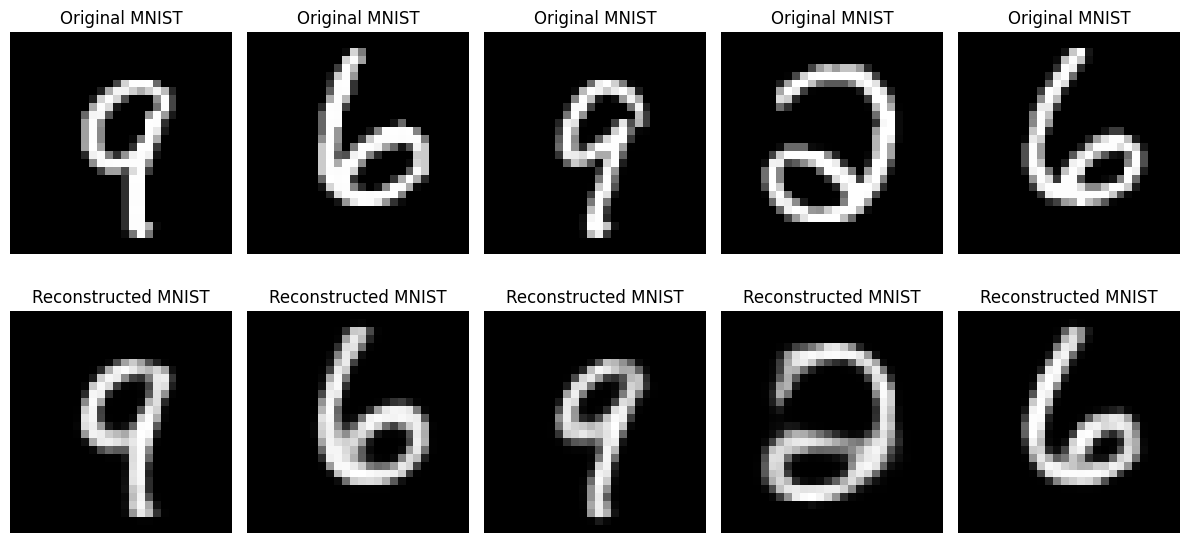

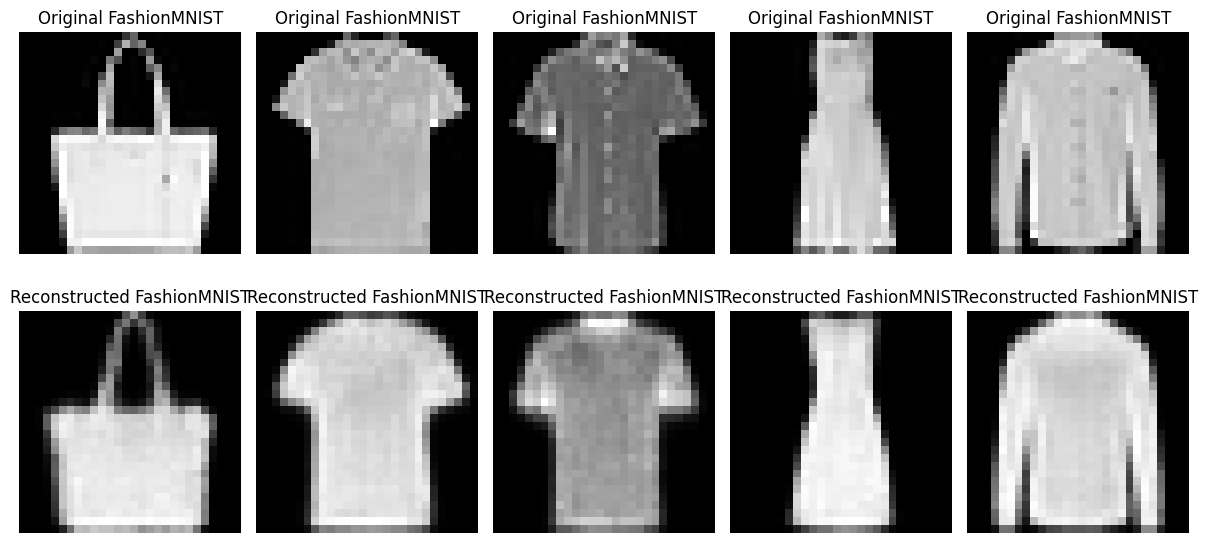

In [30]:
print('***************************************************************************')
print(f'MNIST Accuracies: {accuracies_mnist}')
print(f'FashionMNIST Accuracies: {accuracies_fashion_mnist}')
print('***************************************************************************')

# Plot the before and after reconstructed images for MNIST
vaeMNIST.eval()
with torch.no_grad():
    # Get a random batch of test data
    random_idx = random.randint(0, len(test_loader_mnist) - 1)
    for i, (sample_data, _) in enumerate(test_loader_mnist):
        if i == random_idx:
            sample_data = sample_data.to(device)
            sample_data = sample_data.reshape(-1, 1, 28, 28)
            reconstructed_data, _, _ = vaeMNIST(sample_data)
            break

# Plot the original and reconstructed MNIST images
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 6))

for i, ax in enumerate(axes.flatten()):
    if i < 5:
        ax.imshow(sample_data[i, 0].cpu().numpy(), cmap='gray')
        ax.set_title('Original MNIST')
        ax.axis('off')
    else:
        ax.imshow(reconstructed_data[i - 5, 0].cpu().detach().numpy(), cmap='gray')
        ax.set_title('Reconstructed MNIST')
        ax.axis('off')

plt.tight_layout()
plt.show()

# Plot the before and after reconstructed images for FashionMNIST
vaeFashionMNIST.eval()
with torch.no_grad():
    # Get a random batch of test data
    random_idx = random.randint(0, len(test_loader_fashion_mnist) - 1)
    for i, (sample_data, _) in enumerate(test_loader_fashion_mnist):
        if i == random_idx:
            sample_data = sample_data.to(device)
            sample_data = sample_data.reshape(-1, 1, 28, 28)
            reconstructed_data, _, _ = vaeFashionMNIST(sample_data)
            break

# Plot the original and reconstructed FashionMNIST images
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 6))

for i, ax in enumerate(axes.flatten()):
    if i < 5:
        ax.imshow(sample_data[i, 0].cpu().numpy(), cmap='gray')
        ax.set_title('Original FashionMNIST')
        ax.axis('off')
    else:
        ax.imshow(reconstructed_data[i - 5, 0].cpu().detach().numpy(), cmap='gray')
        ax.set_title('Reconstructed FashionMNIST')
        ax.axis('off')

plt.tight_layout()
plt.show()